# CSE599 Homework 2 

Discussed with Jacob, Mark, Manya

# 1

### a

Grad x Input takes the gradient of the model output with respect to the input features and multiplies it by the input features to show which features contribute the most.
SmoothGrad adds Gaussian noise to samples of image x, calculates the gradients of each of these samples and then averages them to compute a saliency map that is less affected by random noise. 
Integraded Gradients takes the integral of gradients in steps along a path from the input to the baseline and multiplies by the difference between input and baseline, which does not distrupt the sensitivity of the model since the gradients are being taken with respect to small changes in the input not large ones.  

### b

GradCAM takes the gradients with respect to the final hidden layer in the convolutional network and avergaes it across channels. This gives wieghted importance to areas on the final layer which show feature importance. 

### C

Abalation is more suitable for testing if an explanation identifies important features for a specific model because you are evaluating how the model prediction changes by adding/ removing features in an order of importance. Abalation metric show if the important features are actually what the model deems as important based off how the prediction changes with or without them. The ground truth shows if the important features overlap with what humans deem as important, so it is not the best way to evaluate an explanation's correctness for the model. 

## Premliminaries

In [2]:
import shap
import numpy as np

display_images = shap.datasets.imagenet50()[0].astype('uint8')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
from torchvision import models
model = models.resnet18(pretrained=True)
model = model.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


In [4]:
import torchvision.transforms as transforms
model_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])

])

In [5]:
import torch
images = torch.stack([model_transforms(img) for img in display_images])
pred = model(images).softmax(dim=1)

# 2 Occlusion

### a

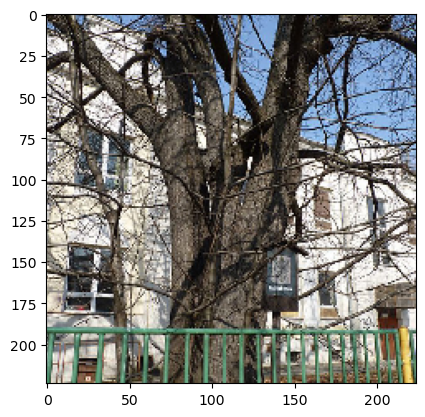

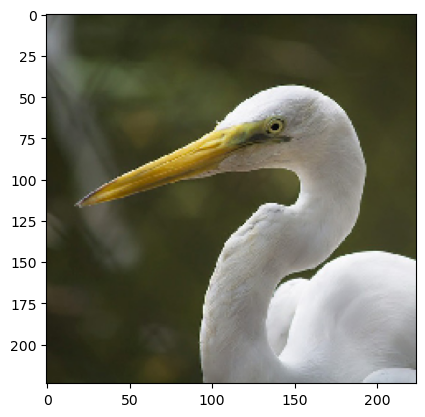

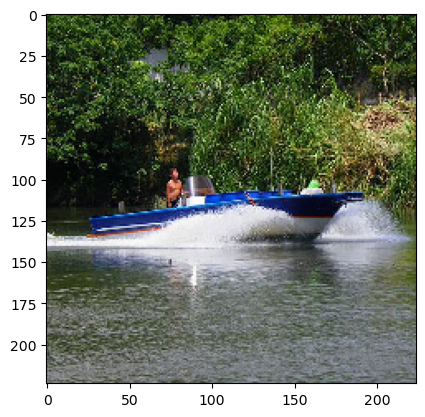

In [6]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.figure()
    plt.imshow(display_images[i])
    plt.show()


### b

In [7]:
image1 = torch.stack([model_transforms(display_images[0])
                      ])
pred1 = model(image1).softmax(dim=1)

In [8]:
image1_class = torch.argmax(pred1)
image1_class_proba = pred1[0,image1_class]

print(image1_class, image1_class_proba)

tensor(829) tensor(0.2936, grad_fn=<SelectBackward0>)


In [9]:
pred1[0,torch.argmax(pred1)]

tensor(0.2936, grad_fn=<SelectBackward0>)

829	streetcar, tram, tramcar, trolley, trolley car

In [10]:
image2 = torch.stack([model_transforms(display_images[1])
                      ])
pred2 = model(image2).softmax(dim=1)

In [11]:
image2_class = torch.argmax(pred2)
image2_class_proba = pred2[0,image2_class]

print(image2_class, image2_class_proba)

tensor(132) tensor(0.9837, grad_fn=<SelectBackward0>)


132	American egret, great white heron, Egretta albus

In [12]:
image3 = torch.stack([model_transforms(display_images[2])
                      ])
pred3 = model(image3).softmax(dim=1)

In [13]:
image3.shape

torch.Size([1, 3, 224, 224])

In [14]:
image3_class = torch.argmax(pred3)
image3_class_proba = pred3[0,image3_class]

print(image3_class, image3_class_proba)

tensor(814) tensor(0.7037, grad_fn=<SelectBackward0>)


814	speedboat

### c

In [15]:
def occlusion(imgs, model, target_labels, baseline, superpixel_size=8):
    '''
    Args:
        imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
        model: PyTorch classifier
        target_labels: torch.Tensor of classes for each image, size = (batch, )
        baseline: baseline value for occluded features
        superpixel_size: width/height of superpixels

    Returns:
        importance: occlusion scores, size = (batch, 224, 224)
    '''
    batch = imgs.size(0)
    image_size = imgs.size(2)
    super_pixel_count = image_size**2 / superpixel_size**2
    count = int(np.sqrt(super_pixel_count))
    occlusion_scores = np.zeros((batch, 224, 224))

    for index, image in enumerate(imgs):
        i = j = 0

        for i in range(count):
            for j in range(count):
                copy_image = image.clone()
                copy_image[ :, (0+superpixel_size*i) : (superpixel_size+superpixel_size*i), (0+superpixel_size*j) : (superpixel_size+superpixel_size*j) ] = baseline[:, (0+superpixel_size*i) : (superpixel_size+superpixel_size*i), (0+superpixel_size*j) : (superpixel_size+superpixel_size*j) ]
                occ_image = torch.unsqueeze(copy_image, dim = 0)
                pred = model(occ_image).softmax(dim=1)
                score = target_labels[index, 1] - pred[0,int(target_labels[index, 0 ])]
                occlusion_scores[index, (0+superpixel_size*i) : (superpixel_size+superpixel_size*i), (0+superpixel_size*j) : (superpixel_size+superpixel_size*j) ] = score.detach()


    return occlusion_scores

In [49]:
first_3_img = images[0:3]
baseline = model_transforms(np.zeros((224,224,3), np.uint8))
image_classes = [int(image1_class), int(image2_class), int(image3_class)]
image_class_proba = [image1_class_proba, image2_class_proba, image3_class_proba]
class_tensor = torch.tensor(image_classes, dtype=torch.int32)
proba_tensor = torch.tensor(image_class_proba, dtype=torch.float32)

target_labels = torch.stack([class_tensor, proba_tensor], dim=1)


In [17]:
out = occlusion(imgs = first_3_img, model = model, target_labels = target_labels, baseline = baseline, superpixel_size=8)

Text(0.5, 1.0, 'Image 1')

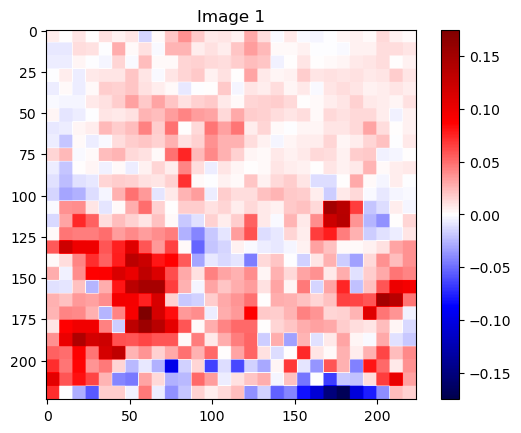

In [18]:

single_importance = out[0]
plt.figure()
n=np.max(np.abs(single_importance))
plt.imshow(single_importance, vmin=-n, vmax=n, cmap='seismic')
plt.colorbar()
plt.title("Image 1")


Text(0.5, 1.0, 'Image 2')

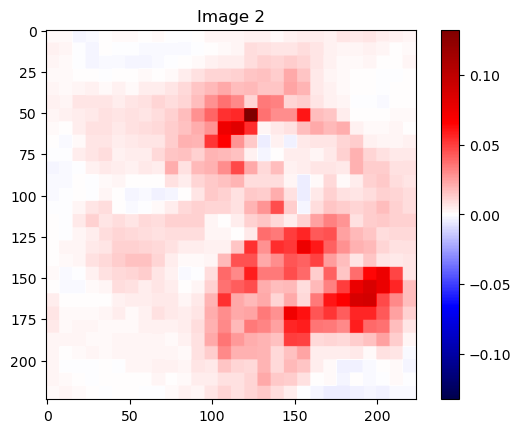

In [19]:
single_importance = out[1]
plt.figure()
n=np.max(np.abs(single_importance))
plt.imshow(single_importance, vmin=-n, vmax=n, cmap='seismic')
plt.colorbar()
plt.title("Image 2")


Text(0.5, 1.0, 'Image 3')

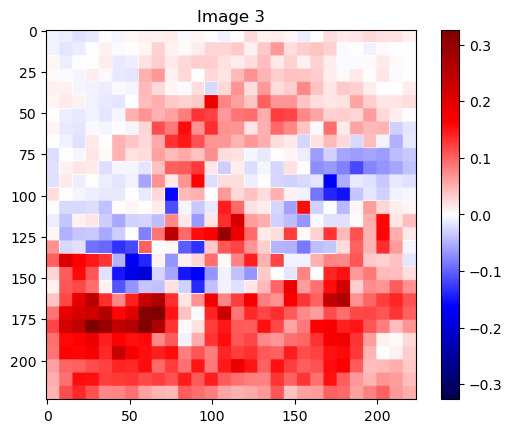

In [20]:
single_importance = out[2]
plt.figure()
n=np.max(np.abs(single_importance))
plt.imshow(single_importance, vmin=-n, vmax=n, cmap='seismic')
plt.colorbar()
plt.title("Image 3")


### d

In [21]:
out4 = occlusion(imgs = first_3_img, model = model, target_labels = target_labels, baseline = baseline, superpixel_size=4)

In [22]:
out16 = occlusion(imgs = first_3_img, model = model, target_labels = target_labels, baseline = baseline, superpixel_size=16)

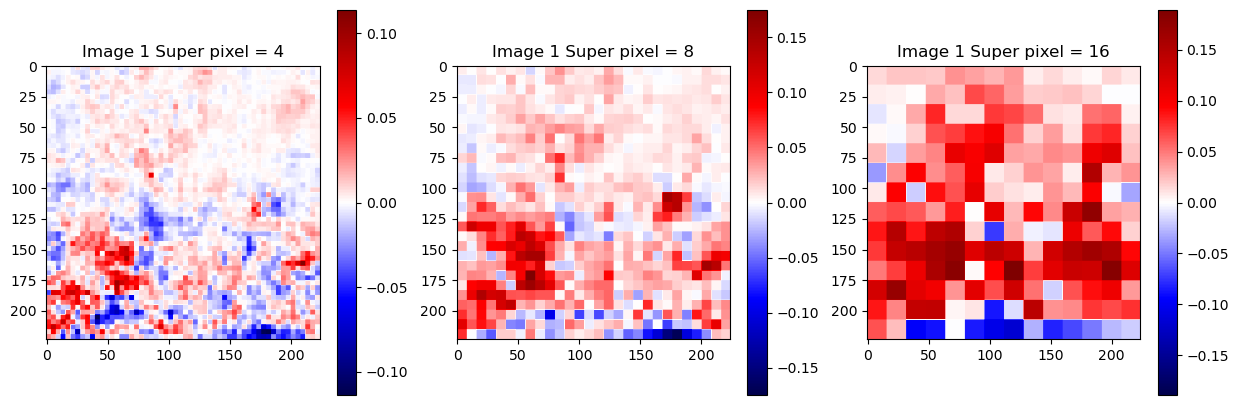

In [23]:
n_1_4 = np.max(np.abs(out4[0]))
n_1_8 = np.max(np.abs(out[0]))
n_1_16 = np.max(np.abs(out16[0]))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(out4[0], vmin=-n_1_4, vmax=n_1_4, cmap='seismic')
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Image 1 Super pixel = 4")

# Plot second image
im2 = axs[1].imshow(out[0], vmin=-n_1_8, vmax=n_1_8, cmap='seismic')
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Image 1 Super pixel = 8")

# Plot third image
im3 = axs[2].imshow(out16[0], vmin=-n_1_16, vmax=n_1_16, cmap='seismic')
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("Image 1 Super pixel = 16")

plt.show()

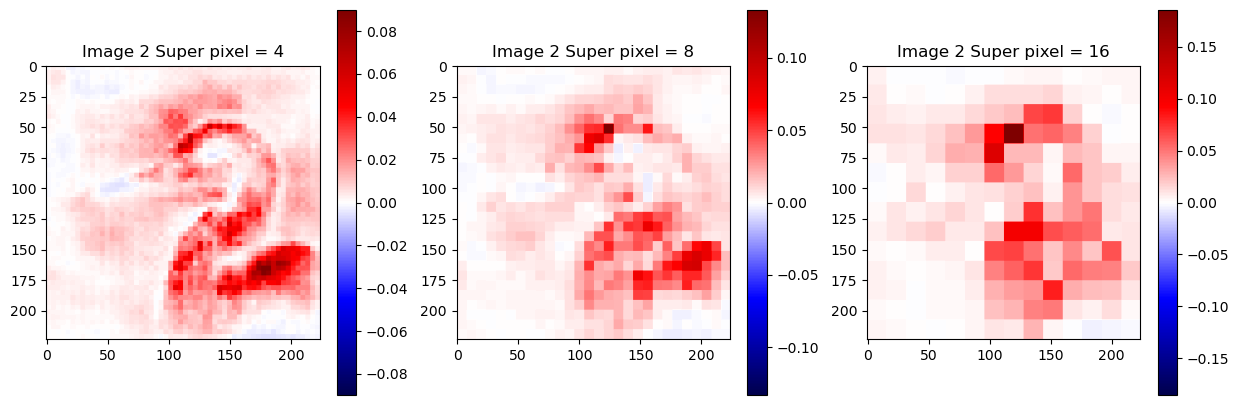

In [24]:
n_2_4 = np.max(np.abs(out4[1]))
n_2_8 = np.max(np.abs(out[1]))
n_2_16 = np.max(np.abs(out16[1]))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(out4[1], vmin=-n_2_4, vmax=n_2_4, cmap='seismic')
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Image 2 Super pixel = 4")

# Plot second image
im2 = axs[1].imshow(out[1], vmin=-n_2_8, vmax=n_2_8, cmap='seismic')
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Image 2 Super pixel = 8")

# Plot third image
im3 = axs[2].imshow(out16[1], vmin=-n_2_16, vmax=n_2_16, cmap='seismic')
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("Image 2 Super pixel = 16")

plt.show()

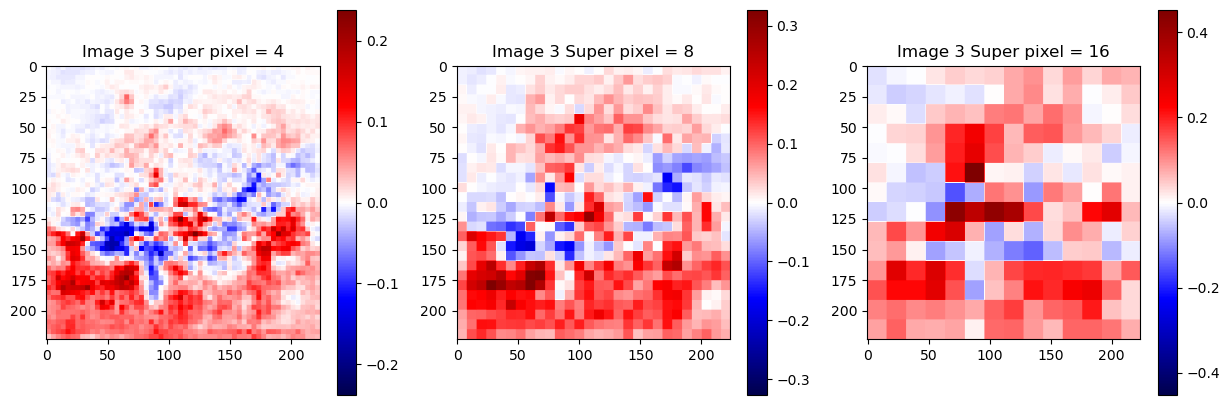

In [25]:
n_3_4 = np.max(np.abs(out4[2]))
n_3_8 = np.max(np.abs(out[2]))
n_3_16 = np.max(np.abs(out16[2]))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(out4[2], vmin=-n_3_4, vmax=n_3_4, cmap='seismic')
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Image 3 Super pixel = 4")

# Plot second image
im2 = axs[1].imshow(out[2], vmin=-n_3_8, vmax=n_3_8, cmap='seismic')
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Image 3 Super pixel = 8")

# Plot third image
im3 = axs[2].imshow(out16[2], vmin=-n_3_16, vmax=n_3_16, cmap='seismic')
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("Image 3 Super pixel = 16")

plt.show()

### e

In [108]:
import cv2
blurred_image_low = cv2.blur(display_images[0], (10,10))
blurred_image_med = cv2.blur(display_images[0], (20,20))
blurred_image_high = cv2.blur(display_images[0], (30,30))

baseline_low = model_transforms(blurred_image_low)
baseline_med = model_transforms(blurred_image_med)
baseline_high = model_transforms(blurred_image_high)
image_classes = [image1_class]
image_class_proba = [image1_class_proba]
class_tensor = torch.tensor(image_classes, dtype=torch.int32)
proba_tensor = torch.tensor(image_class_proba, dtype=torch.float32)

target_labels = torch.stack([class_tensor, proba_tensor], dim=1)
first_img = first_3_img[0].unsqueeze(0)

In [109]:
out_low_blur = occlusion(imgs = first_img, model = model, target_labels = target_labels, baseline = baseline_low, superpixel_size=8)

In [110]:
out_med_blur = occlusion(imgs = first_img, model = model, target_labels = target_labels, baseline = baseline_med, superpixel_size=8)

In [111]:
out_high_blur = occlusion(imgs = first_img, model = model, target_labels = target_labels, baseline = baseline_high, superpixel_size=8)

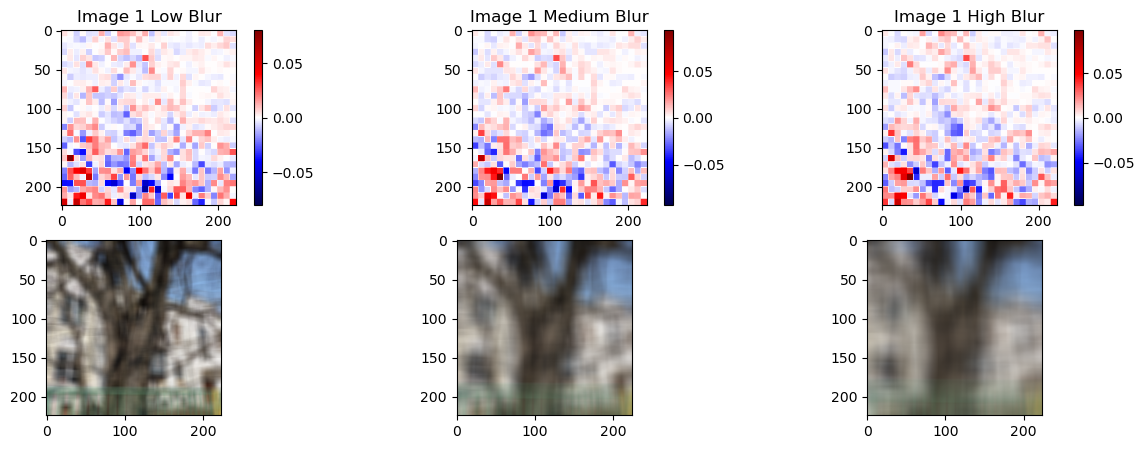

In [117]:
n_low = np.max(np.abs(out_low_blur[0]))
n_med = np.max(np.abs(out_med_blur[0]))
n_high = np.max(np.abs(out_high_blur[0]))


fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# Low blur
im1 = axs[0,0].imshow(out_low_blur[0], vmin=-n_low, vmax=n_low, cmap='seismic')
fig.colorbar(im1, ax=axs[0,0])
axs[0,0].set_title("Image 1 Low Blur")

im1_blur = axs[1,0].imshow(blurred_image_low)


# Med blur
im2 = axs[0,1].imshow(out_med_blur[0], vmin=-n_med, vmax=n_med, cmap='seismic')
fig.colorbar(im2, ax=axs[0,1])
axs[0,1].set_title("Image 1 Medium Blur")
im2_blur = axs[1,1].imshow(blurred_image_med)

# High Blur
im3 = axs[0,2].imshow(out_high_blur[0], vmin=-n_high, vmax=n_high, cmap='seismic')
fig.colorbar(im3, ax=axs[0,2])
axs[0,2].set_title("Image 1 High Blur")
im3_blur = axs[1,2].imshow(blurred_image_high)




plt.show()

# 3 Gradient-Based Explanations

### a

In [34]:
def calculate_gradients(imgs, model, target_labels):
    '''
    Args:
        imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
        model: PyTorch classifer
        target_labels: torch.Tensor of classes for each image, shape = (batch, )

    Returns:
        gradients: gradients for the target class, shape = (batch, 3, 244, 244)
    '''

    # Prepare for model
    imgs = imgs.clone()
    imgs.requires_grad = True

    # Make output prediction
    output = model(imgs).softmax(dim=1)

    #Sum outputs for target classes
    mask = torch.zeros(output.shape)
    for i, target in enumerate(target_labels):
        mask[i, target] = 1
    backprop_output = torch.sum(output * mask)

    #Calculate gradients
    model.zero_grad()
    backprop_output.backward()

    #Convert gradients to numpy
    gradients = imgs.grad.detach()


    return gradients

In [38]:
def vanilla_gradients(imgs, model, target_labels):

    '''
    Args:
        imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
        model: PyTorch classifier
        target_labels: torch.Tensor of classes for each image, size = (batch, )

    Returns:
        saliency: tensor of saliency values, shape = (batch, 244, 244)
    '''

    gradients = calculate_gradients(imgs = imgs, model = model, target_labels=target_labels)

    abs = gradients.abs()

    saliency = abs.sum(dim = 1)




    return saliency

In [50]:
vanilla = vanilla_gradients(imgs = first_3_img, model = model, target_labels=class_tensor)

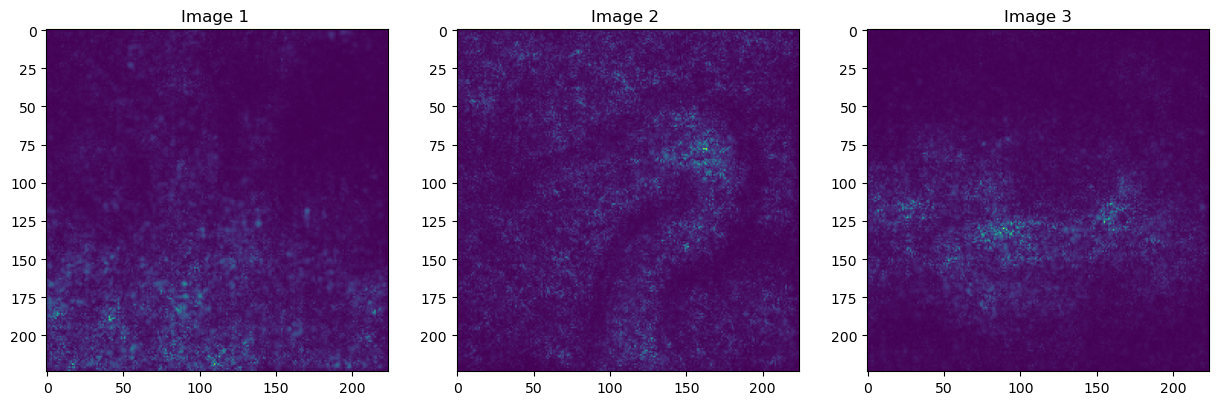

In [51]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(vanilla[0] , vmin =0 , vmax = vanilla[0].max()) # specify min /max value
axs[0].set_title("Image 1 ")

# Plot second image
im2 = axs[1].imshow(vanilla[1] , vmin =0 , vmax = vanilla[1].max()) # specify min /max value
axs[1].set_title("Image 2 ")

# Plot third image
im3 = axs[2].imshow(vanilla[2] , vmin =0 , vmax = vanilla[2].max()) # specify min /max value
axs[2].set_title("Image 3")

plt.show()

### b

In [47]:
def smoothgrad(imgs, model, target_labels, samples = 50, sigma = 0.1):
    '''
    Args:
        imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
        model: PyTorch classifier
        target_labels: torch.Tensor of classes for each image, size = (batch, )
        samples: number of random noise samples
        sigma: scale for random noise

    Returns:
        saliency: tensor of saliency values, shape = (batch, 244, 244)
    '''
    average_grad = []
    for index, img in enumerate(imgs):
        noisy_images = []

        for i in range(samples):
            noise = img + sigma*torch.rand(img.shape)
            noisy_images.append(noise)

        image_tensor = torch.stack(noisy_images, dim=0)
        class_tensor = torch.full((samples,), int(target_labels[index]))
        gradients = calculate_gradients(image_tensor, model, class_tensor)
        average_grad.append(gradients.abs().mean(dim = 0))


    saliency = torch.stack(average_grad, dim = 0).sum(dim = 1)



    return saliency

In [52]:
smooth = smoothgrad(imgs = first_3_img, model = model, target_labels = class_tensor, samples = 50, sigma = 0.1)

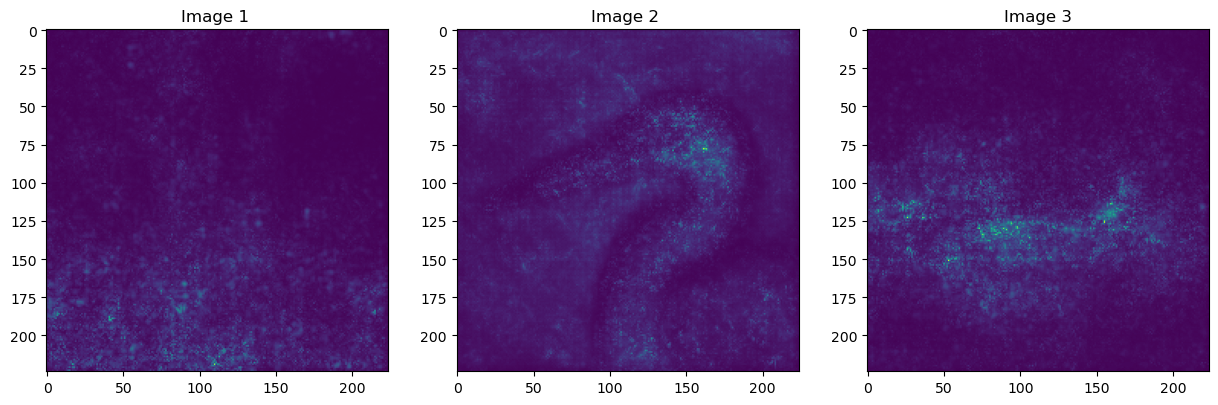

In [53]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(smooth[0] , vmin =0 , vmax = smooth[0].max()) # specify min /max value
axs[0].set_title("Image 1 ")

# Plot second image
im2 = axs[1].imshow(smooth[1] , vmin =0 , vmax = smooth[1].max()) # specify min /max value
axs[1].set_title("Image 2 ")

# Plot third image
im3 = axs[2].imshow(smooth[2] , vmin =0 , vmax = smooth[2].max()) # specify min /max value
axs[2].set_title("Image 3")

plt.show()

### c

In [54]:
def intergrated_gradients(imgs, model, target_labels, baseline, steps = 50):
    '''
    Args:
        imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
        model: PyTorch classifier
        target_labels: torch.Tensor of classes for each image, size = (batch, )
        baseline: baseline value for held-out features
        steps: number of steps along path to baseline

    Returns:
        saliency: tensor of saliency values, shape = (batch, 244, 244)
    '''

    sal_list = []

    for index, img in enumerate(imgs):
        interp_list = []
        average_grad = []

        diff = img - baseline

        for alpha in torch.linspace(0.0, 1.0, steps):
            interp_img = baseline + alpha * diff
            interp_list.append(interp_img)

        image_tensor = torch.stack(interp_list, dim=0)
        class_tensor = torch.full((steps,), int(target_labels[index]))
        gradients = calculate_gradients(image_tensor, model, class_tensor)
        average_grad.append(gradients.abs().mean(dim = 0))

        avg_grad_tensor = torch.stack(average_grad, dim = 0)

        sal_val = avg_grad_tensor*(diff)
        sal_list.append(sal_val)

    saliency = torch.cat(sal_list, dim = 0).abs().sum(dim =1)

    return saliency


In [55]:
baseline = model_transforms(np.zeros((224,224,3), np.uint8))

In [56]:
int_out = intergrated_gradients(imgs = first_3_img, model = model, target_labels = class_tensor, baseline= baseline, steps = 50)

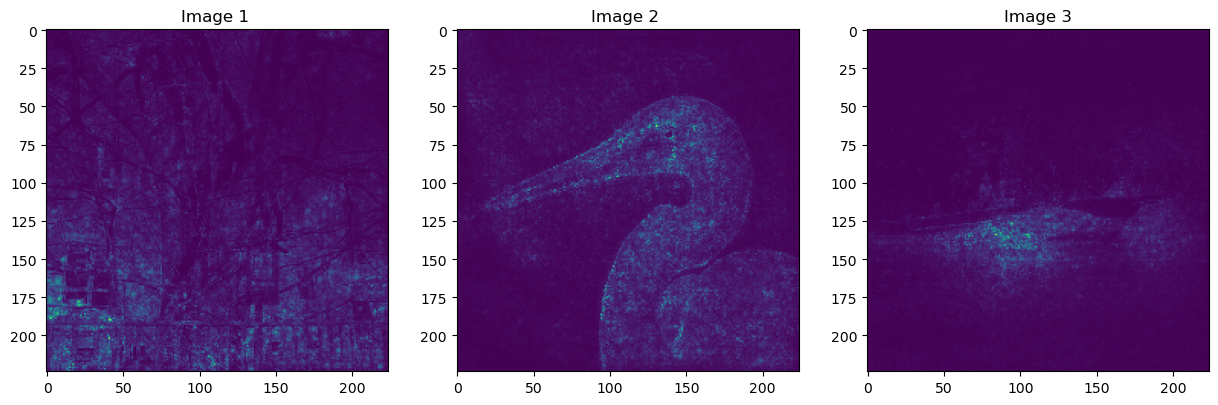

In [57]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(int_out[0] , vmin =0 , vmax = int_out[0].max()) # specify min /max value
axs[0].set_title("Image 1 ")

# Plot second image
im2 = axs[1].imshow(int_out[1] , vmin =0 , vmax = int_out[1].max()) # specify min /max value
axs[1].set_title("Image 2 ")

# Plot third image
im3 = axs[2].imshow(int_out[2] , vmin =0 , vmax = int_out[2].max()) # specify min /max value
axs[2].set_title("Image 3")

plt.show()

### d

In [58]:
# Generate white image , then apply pre - processing
white_baseline = model_transforms(255*np.ones ((224 , 224 , 3) , np.uint8 ))

In [59]:
int_out_white = intergrated_gradients(imgs = first_3_img, model = model, target_labels = class_tensor, baseline= white_baseline, steps = 50)

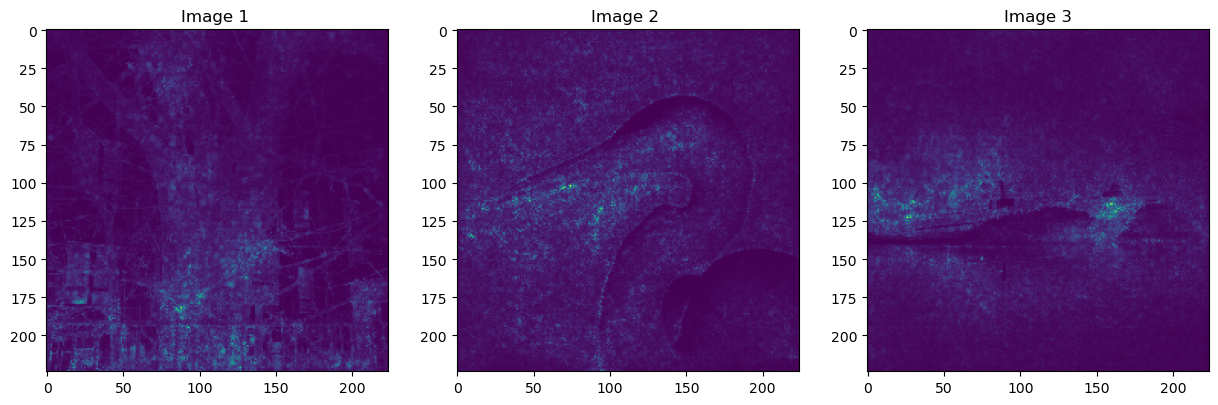

In [60]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first image
im1 = axs[0].imshow(int_out_white[0] , vmin =0 , vmax = int_out_white[0].max()) # specify min /max value
axs[0].set_title("Image 1 ")

# Plot second image
im2 = axs[1].imshow(int_out_white[1] , vmin =0 , vmax = int_out_white[1].max()) # specify min /max value
axs[1].set_title("Image 2 ")

# Plot third image
im3 = axs[2].imshow(int_out_white[2] , vmin =0 , vmax = int_out_white[2].max()) # specify min /max value
axs[2].set_title("Image 3")

plt.show()

# 4 Abalation Metrics

### a

In [61]:
first_10_img = images[0:10]

image_class_list = []
image_class_proba_list = []


for i in range(10):

    image = torch.stack([model_transforms(display_images[i])])
    pred = model(image).softmax(dim=1)
    image_class = torch.argmax(pred)
    image_class_proba = pred[0, image_class]

    image_class_list.append(int(image_class))
    image_class_proba_list.append(image_class_proba)


class_tensor = torch.tensor(image_class_list, dtype=torch.int32)
proba_tensor = torch.tensor(image_class_proba_list, dtype=torch.float32)
target_labels = torch.stack([class_tensor, proba_tensor], dim=1)

baseline = model_transforms(np.zeros((224,224,3), np.uint8))




In [62]:
out = occlusion(imgs = first_10_img, model = model, target_labels = target_labels, baseline = baseline, superpixel_size=8)

In [63]:
smooth = smoothgrad(imgs = first_10_img, model = model, target_labels = class_tensor, samples = 50, sigma = 0.1)

In [64]:
rand_img = torch.rand(10,244,244)

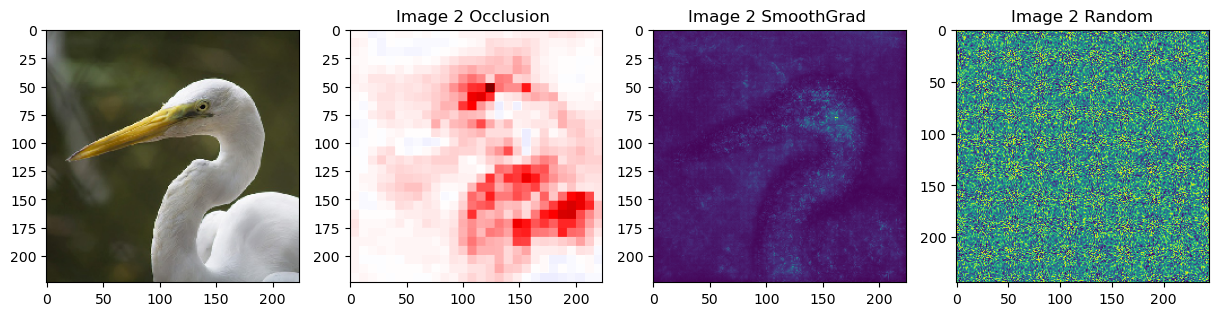

In [130]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot first image
im0 = axs[0].imshow(display_images[1])

im1 = axs[1].imshow(out[1] , vmin = -np.max(np.abs(out[1])) , vmax = np.max(np.abs(out[1])), cmap = 'seismic') #specify min /max value
axs[1].set_title("Image 2 Occlusion ")

# Plot second image
im2 = axs[2].imshow(smooth[1] , vmin =0 , vmax = smooth[1].max()) # specify min /max value
axs[2].set_title("Image 2 SmoothGrad ")

# Plot third image
im3 = axs[3].imshow(rand_img[1] , vmin =0 , vmax = rand_img[1].max()) # specify min /max value
axs[3].set_title("Image 2 Random")

plt.show()

### b

In [66]:
import torch.nn.functional

m = torch.nn.AvgPool2d(kernel_size=8, stride=8)

smooth_pooled = m(smooth)
random_pooled = m(rand_img)
occl_pooled = m(torch.tensor(out))

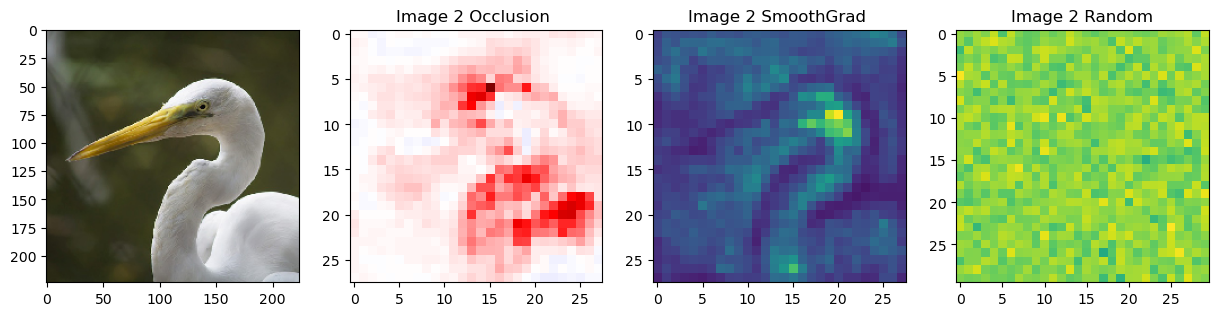

In [134]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot first image
im0 = axs[0].imshow(display_images[1])

im1 = axs[1].imshow(occl_pooled[1] , vmin = -occl_pooled[1].abs().max() , vmax = occl_pooled[1].abs().max(), cmap = 'seismic') #specify min /max value
axs[1].set_title("Image 2 Occlusion ")

# Plot second image
im2 = axs[2].imshow(smooth_pooled[1] , vmin =0 , vmax = smooth_pooled[1].max()) # specify min /max value
axs[2].set_title("Image 2 SmoothGrad ")

# Plot third image
im3 = axs[3].imshow(random_pooled[1] , vmin =0 , vmax = random_pooled[1].max()) # specify min /max value
axs[3].set_title("Image 2 Random")

plt.show()

### c

In [67]:
baseline = model_transforms(np.zeros ((224 , 224 , 3), np.uint8))


In [142]:
def insertion(imgs, model, importance, target_label, baseline):
    '''
    Args:
        imgs: image to ablate, size = (1,3,224,224)
        model: PyTorch classifier
        importance: features importance values, size = (1,28,28)
        target_label: index of target class
        baseline: baseline value for held-out feature

    Returns:
        curve: array of prediction probabilites after each step
        num_feats: array of number of featrues after each step
    '''

    flat_indices = torch.argsort(importance.flatten(), descending=True)
    cols = importance.shape[2]
    sorted_indices = [(index // cols, index % cols) for index in flat_indices]

    copy_image = imgs.clone()
    copy_baseline = baseline.clone()
    pred_list = []
    num_list = []
    count = 0

    for index in sorted_indices:
        row = index[0]
        col = index[1]
        copy_baseline[:, :, (0+8*row) : (8+8*row), (0+8*col) : (8+8*col) ] = copy_image[:,:, (0+8*row) : (8+8*row), (0+8*col) : (8+8*col) ]

        pred = model(copy_baseline).softmax(dim=1)
        pred_proba = pred[0,target_label]
        pred_list.append(pred_proba.item())

        count += 1
        num_list.append(count)


    curve = np.array(pred_list)
    num_feats = np.array(num_list)


    return curve, num_feats

In [143]:
ins_curve, ins_num_feats = insertion(imgs = first_10_img[2].unsqueeze(0), model = model, importance = occl_pooled[2].unsqueeze(0), target_label = 814, baseline = baseline.unsqueeze(0))

Text(0.5, 0, 'Num Features Inserted')

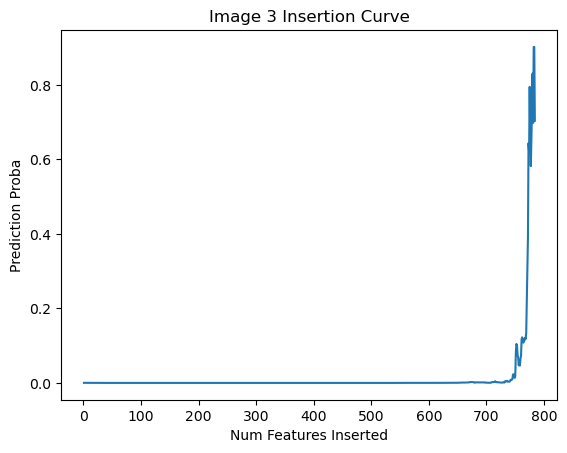

In [144]:
plt.plot(ins_num_feats, ins_curve)
plt.title("Image 3 Insertion Curve")
plt.ylabel("Prediction Proba")
plt.xlabel('Num Features Inserted')

In [71]:
from scipy import integrate
auc = integrate.trapezoid(ins_curve, x=ins_num_feats) / 784
auc

0.014533964108802519

### d

In [145]:
def deletion(imgs, model, importance, target_label, baseline):
    '''
    Args:
        imgs: image to ablate, size = (1,3,224,224)
        model: PyTorch classifier
        importance: features importance values, size = (1,28,28)
        target_label: index of target class
        baseline: baseline value for held-out feature

    Returns:
        curve: array of prediction probabilites after each step
        num_feats: array of number of featrues after each step
    '''

    flat_indices = torch.argsort(importance.flatten(), descending=True)
    cols = importance.shape[2]
    sorted_indices = [(index // cols, index % cols) for index in flat_indices]

    copy_image = imgs.clone()
    copy_baseline = baseline.clone()
    pred_list = []
    num_list = []
    count = 0

    for index in sorted_indices:
        row = index[0]
        col = index[1]
        copy_image[:,:, (0+8*row) : (8+8*row), (0+8*col) : (8+8*col) ] = copy_baseline[:, :, (0+8*row) : (8+8*row), (0+8*col) : (8+8*col) ]

        pred = model(copy_image).softmax(dim=1)
        pred_proba = pred[0,target_label]
        pred_list.append(pred_proba.item())

        count += 1
        num_list.append(count)


    curve = np.array(pred_list)
    num_feats = np.array(num_list)


    return curve, num_feats

In [73]:
del_curve, del_num_feats = deletion(imgs = first_10_img[2].unsqueeze(0), model = model, importance = occl_pooled[2].unsqueeze(0), target_label = 814, baseline = baseline.unsqueeze(0))

Text(0.5, 0, 'Num_Features Deleted')

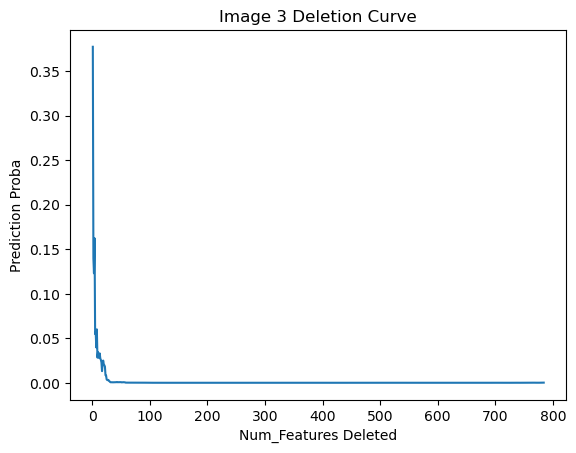

In [74]:
plt.plot(del_num_feats, del_curve)
plt.title("Image 3 Deletion Curve")
plt.ylabel("Prediction Proba")
plt.xlabel('Num_Features Deleted')

In [75]:
from scipy import integrate
auc = integrate.trapezoid(del_curve, x=del_num_feats) / 784
auc

0.0015807473657511823

### e

Insertion with Occlusion for all 10 

In [76]:
occlusion_ins_list = []
for i in range(10):
    ins_curve, occ_ins_num_feats = insertion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = occl_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    occlusion_ins_list.append(ins_curve)

occ_ins_avg_curve = np.mean(np.array(occlusion_ins_list), axis = 0)



Text(0.5, 0, 'Num Features Inserted')

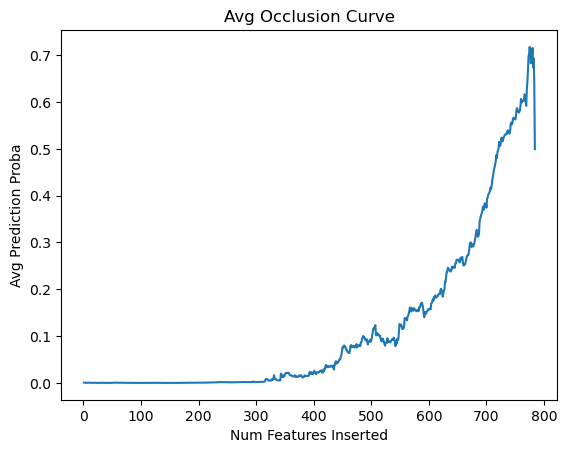

In [77]:
plt.plot(occ_ins_num_feats, occ_ins_avg_curve)
plt.title("Avg Occlusion Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Inserted')

In [78]:
from scipy import integrate
auc = integrate.trapezoid(occ_ins_avg_curve, x=occ_ins_num_feats) / 784
auc

0.11644762004728315

Insertion with Smooth for all 10 

In [79]:
smooth_ins_list = []
for i in range(10):
    ins_curve, smooth_ins_num_feats = insertion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = smooth_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    smooth_ins_list.append(ins_curve)

smo_ins_avg_curve = np.mean(np.array(smooth_ins_list), axis = 0)

Text(0.5, 0, 'Num Features Inserted')

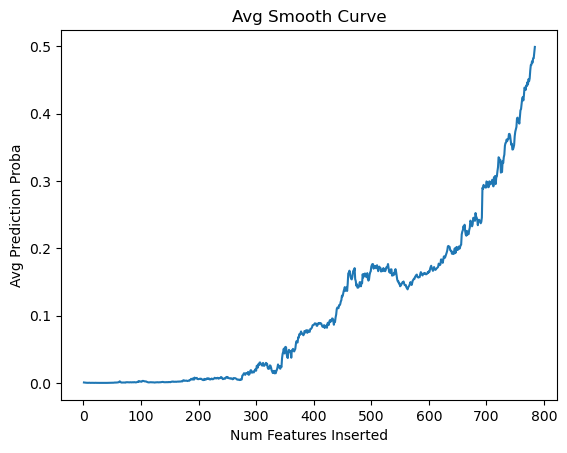

In [80]:
plt.plot(smooth_ins_num_feats, smo_ins_avg_curve)
plt.title("Avg Smooth Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Inserted')

In [81]:
from scipy import integrate
auc = integrate.trapezoid(smo_ins_avg_curve, x=smooth_ins_num_feats) / 784
auc

0.11022881056620182

Insertion with Random for all 10

In [82]:
rand_ins_list = []
for i in range(10):
    ins_curve, rand_ins_num_feats = insertion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = random_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    rand_ins_list.append(ins_curve)

rand_ins_avg_curve = np.mean(np.array(rand_ins_list), axis = 0)

Text(0.5, 0, 'Num Features Inserted')

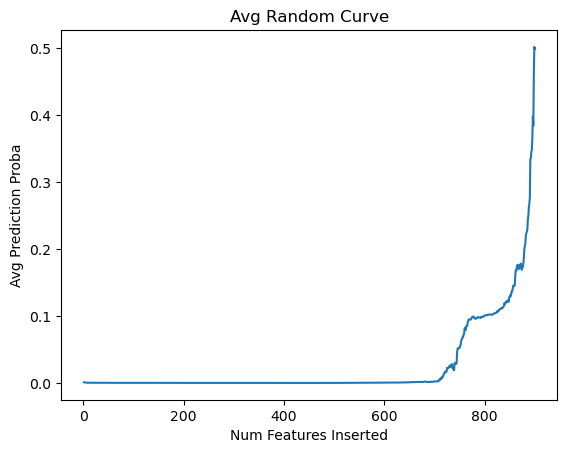

In [83]:
plt.plot(rand_ins_num_feats, rand_ins_avg_curve)
plt.title("Avg Random Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Inserted')

In [84]:
from scipy import integrate
auc = integrate.trapezoid(rand_ins_avg_curve, x=rand_ins_num_feats) / 784
auc

0.028289851622351106

### f

Deletion with Occlusion for all 10 

In [86]:
occlusion_del_list = []
for i in range(10):
    del_curve, occ_del_num_feats = deletion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = occl_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    occlusion_del_list.append(del_curve)

occ_del_avg_curve = np.mean(np.array(occlusion_del_list), axis = 0)



Text(0.5, 0, 'Num Features Deleted')

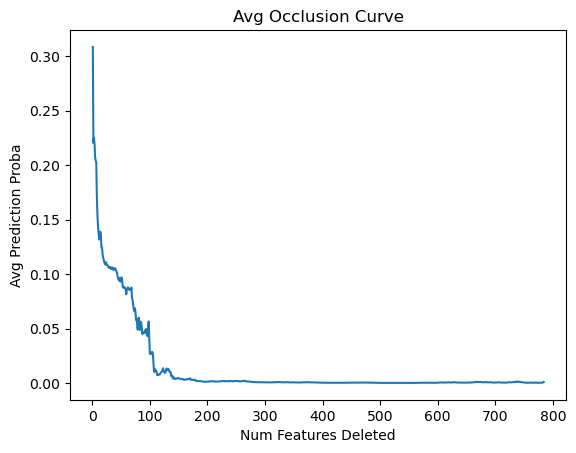

In [87]:
plt.plot(occ_del_num_feats, occ_del_avg_curve)
plt.title("Avg Occlusion Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Deleted')

In [88]:
from scipy import integrate
auc = integrate.trapezoid(occ_del_avg_curve, x=occ_del_num_feats) / 784
auc

0.01363578560530909

Deletion with Smooth for all 10 

In [91]:
smooth_del_list = []
for i in range(10):
    del_curve, smooth_del_num_feats = deletion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = smooth_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    smooth_del_list.append(del_curve)

smo_del_avg_curve = np.mean(np.array(smooth_del_list), axis = 0)

Text(0.5, 0, 'Num Features Deleted')

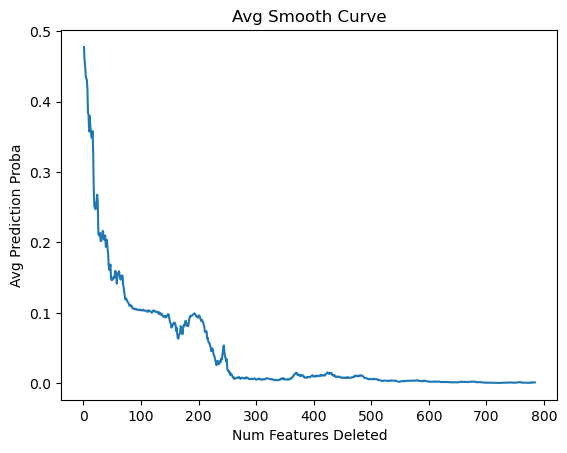

In [92]:
plt.plot(smooth_del_num_feats, smo_del_avg_curve)
plt.title("Avg Smooth Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Deleted')

In [93]:
from scipy import integrate
auc = integrate.trapezoid(smo_del_avg_curve, x=smooth_del_num_feats) / 784
auc

0.043681090865613045

Deletion for Random with all 10

In [94]:
rand_del_list = []
for i in range(10):
    del_curve, rand_del_num_feats = deletion(imgs = first_10_img[i].unsqueeze(0), model = model, importance = random_pooled[i].unsqueeze(0), target_label = class_tensor[i].item(), baseline = baseline.unsqueeze(0))
    rand_del_list.append(del_curve)

rand_del_avg_curve = np.mean(np.array(rand_del_list), axis = 0)

Text(0.5, 0, 'Num Features Inserted')

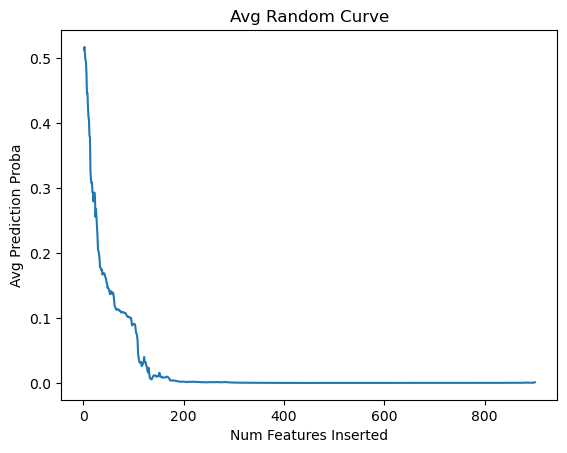

In [95]:
plt.plot(rand_del_num_feats, rand_del_avg_curve)
plt.title("Avg Random Curve")
plt.ylabel("Avg Prediction Proba")
plt.xlabel('Num Features Inserted')

In [96]:
from scipy import integrate
auc = integrate.trapezoid(rand_del_avg_curve, x=rand_del_num_feats) / 784
auc

0.027121149338225424